# Model Interpretability

Check which feature is important using Pytorch's Captum

In [1]:
!pip install captum

In [2]:
import numpy as np

import torch
import torch.nn as nn
torch.manual_seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from captum.attr import IntegratedGradients

Same data parsing, but keep the feature name for later

In [3]:
titanic_training_data = pd.read_csv('kaggle/train.csv')

def clean_titanic(df, train=True):
    df["Cabin"] = df["Cabin"].apply(lambda x: pd.isna(x)).astype(bool)
    df["Embarked"] = df["Embarked"].apply(lambda x: pd.isna(x)).astype(bool)
    df["AgeNan"] = df["Age"].apply(lambda x: pd.isna(x)).astype(bool)
    df = pd.concat([df, pd.get_dummies(df['Sex'], dtype='bool', prefix='sex_'), pd.get_dummies(df['Pclass'], dtype='bool', prefix='pclass_')], axis=1)
    df = df.drop(['PassengerId', 'Name','Ticket','Sex','Pclass'], axis=1)
    if train:
        df = df.drop(['Survived'], axis=1)
    numeric_features = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'bool')].index
    df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.mean()) / (x.std() + 1e-8))
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    return df

labels = torch.tensor(titanic_training_data["Survived"].values, dtype=torch.float32)
titanic_training_data = clean_titanic(titanic_training_data)
titanic_data_tensor = torch.tensor(titanic_training_data.astype('float').values, dtype=torch.float32)
feature_names = list(titanic_training_data.columns)

Load the previously trained Neural Network

In [4]:
def layer_init(m):
    torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
    torch.nn.init.constant_(m.bias, 0)
    return m

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.ln = layer_init(nn.Linear(12, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.ln(x)
        return self.sigmoid(x)
    
net = LinearModel()
net.load_state_dict(torch.load('kaggle/titanic_model.pt'))

<All keys matched successfully>

Use the `IntegratedGradients` technique to check feature importance

As the name implies, this requires to compute gradient on the input data, so we need to activate it

In [5]:
ig = IntegratedGradients(net)
titanic_data_tensor.requires_grad_()
attr, delta = ig.attribute(titanic_data_tensor, target=0, return_convergence_delta=True)
attr = attr.detach().numpy()

This function helper display the features importance

Average Feature Importances
Age :  0.001
SibSp :  0.001
Parch :  -0.000
Fare :  -0.000
Cabin :  -0.180
Embarked :  0.001
AgeNan :  -0.008
sex__female :  0.163
sex__male :  -0.044
pclass__1 :  0.028
pclass__2 :  0.018
pclass__3 :  -0.062


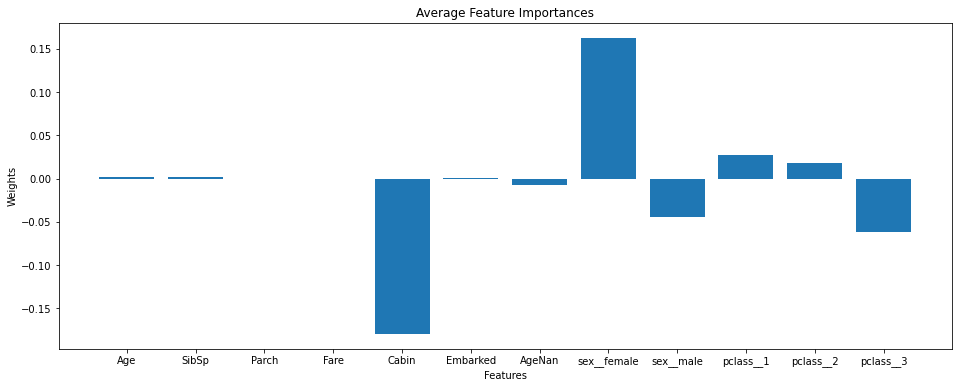

In [6]:
def visualize_importances(feature_names, importances, title="Average Feature Importance", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(16,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.ylabel('Weights')
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))